# Parametric Circuit Fitting Belem

In [122]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def model_pipeline(model, data, num_iter_spam, num_iter_map, N=None):
    d = model.channel.d
    channel = model.channel
    spam = channel.spam
    
    inputs_spam, targets_spam, inputs_map, targets_map = data
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = num_iter_spam,
               verbose = False,
              )
    
    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = num_iter_map,
                )
    
    return model


In [3]:
def spectrum_model(model):
    spectrum = channel_spectrum(model.channel)

    t = np.linspace(0, 2*np.pi, 100)
    circle = [np.sin(t), np.cos(t)]
    
    return spectrum, circle
    

## Three Qubit 

## Belem

In [27]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list =  pickle.load(open("../../data/threeQubits_PQC_noDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model1 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009458874164359992


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006985061888381532 None


In [28]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list =  pickle.load(open("../../data/threeQubits_PQC_10usDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model2 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009223724925260603


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007117507886749474 None


In [29]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list =  pickle.load(open("../../data/threeQubits_PQC_20usDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model3 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008013254563373106


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00661803072337978 None


In [30]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list =  pickle.load(open("../../data/threeQubits_PQC_30usDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model4 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.009691830328212294


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0069271067619719896 None


In [164]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list = pickle.load(open("../../data/threeQubits_PQC_35usDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model5 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.008457447130799557


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009141935546630857 None


In [165]:
n = 3
d = 2**n
rank = d**2
inputs_map, inputs_spam, counts_list = pickle.load(open("../../data/threeQubits_PQC_40usDelay_belem.p", "rb"))

targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=rank,
                                           spam = spam,
                                          ),
                       loss_function = ProbabilityMSE(),
                       optimizer = tf.optimizers.Adam(learning_rate=0.01),
                       logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                       )

model6 = model_pipeline(model, data, num_iter_spam=1000, num_iter_map=2000, N=500)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00976554750896287


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013713613806450468 None


In [181]:
data = [model1.channel, model2.channel, model3.channel, model4.channel, model5.channel, model6.channel]
#data = [model4.channel]
#pickle.dump(data, open("../../data/belem_fitting_extractedKraus.p", "wb"))

C:\Users\krisw\AppData\Local\Temp\ipykernel_13024\3957944648.py:14: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x0000024646630130> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Delay = 0us", "Delay = 10us", "Delay = 20us", "Delay = 30us", "Delay = 35us", "Delay = 40us"])


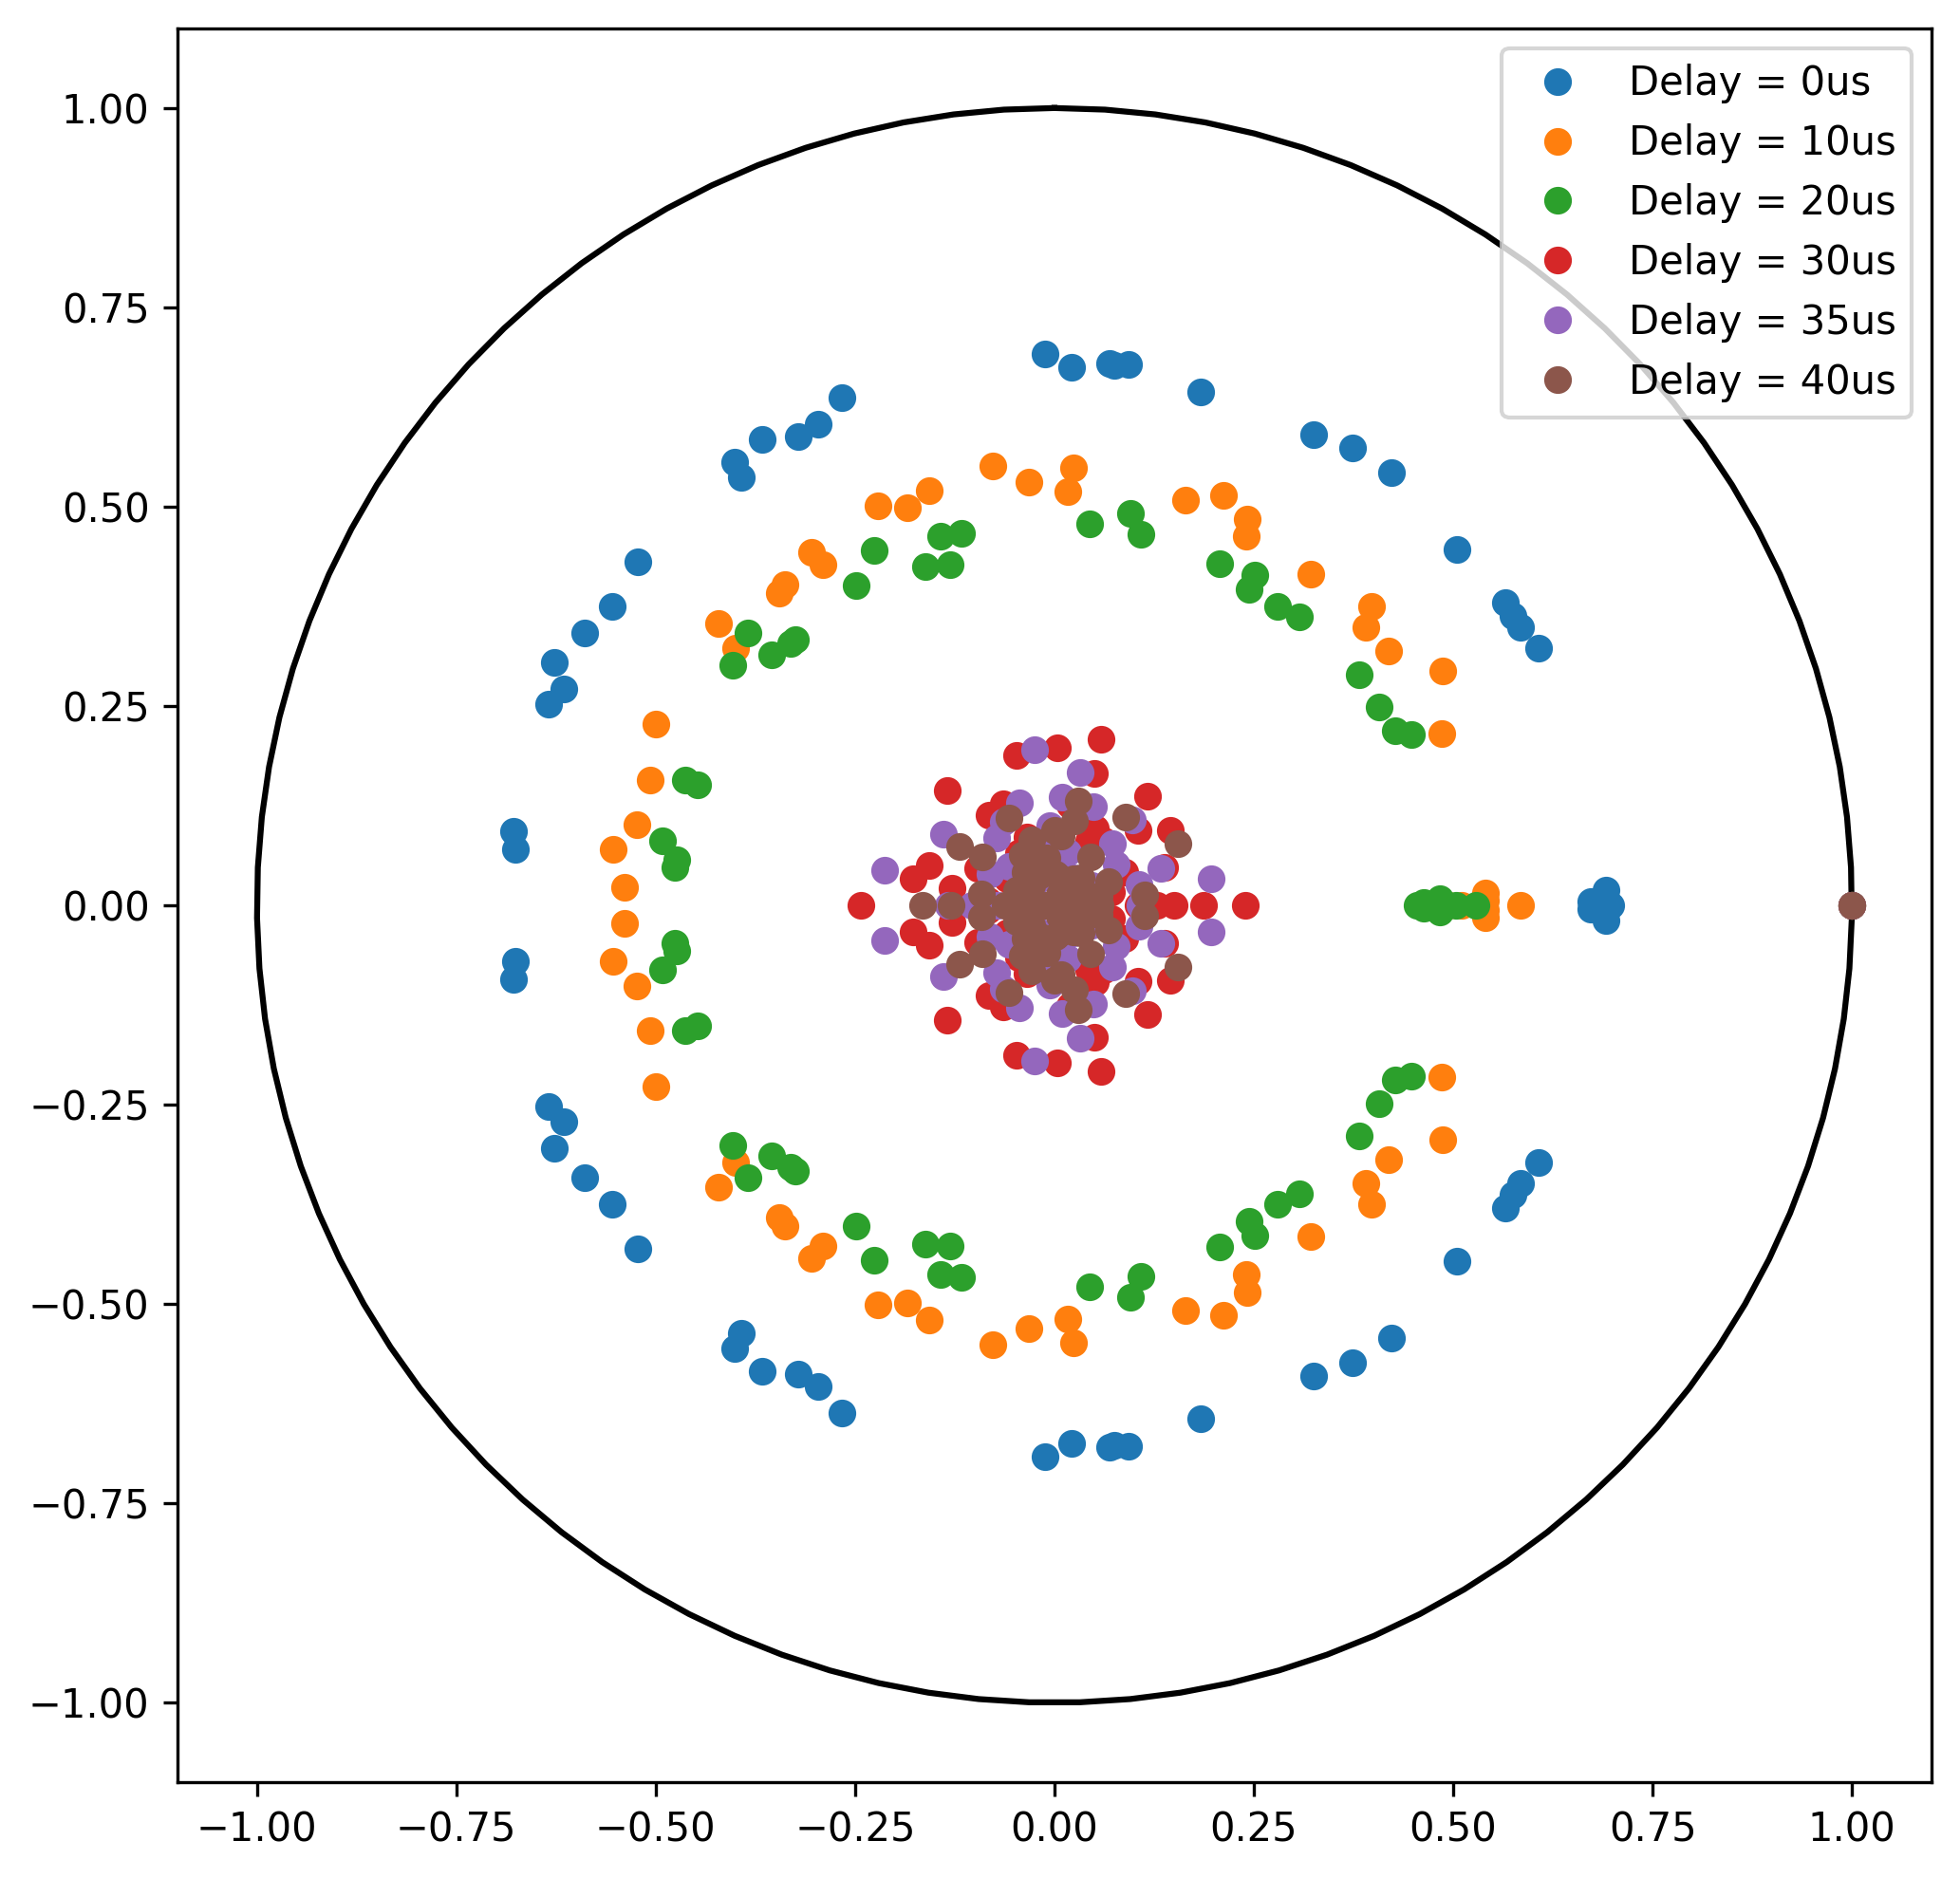

In [187]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

spectrum_list = [channel_spectrum(channel) for channel in data]

fig =plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "o")

plt.legend(["_", "Delay = 0us", "Delay = 10us", "Delay = 20us", "Delay = 30us", "Delay = 35us", "Delay = 40us"])
plt.show()

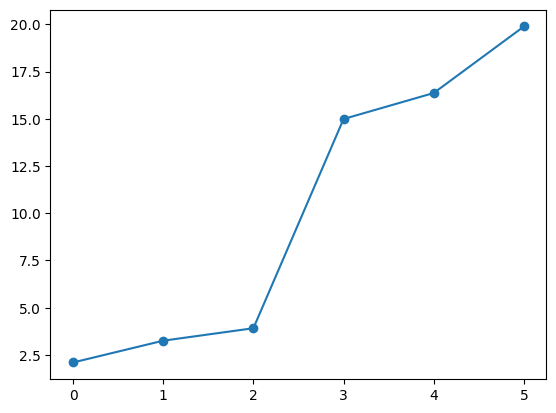

In [186]:
rank_list = [np.real(channel.rank) for channel in data]
eff_rank = [np.real(effective_rank(channel)) for channel in data]
plt.plot(eff_rank, "o-")

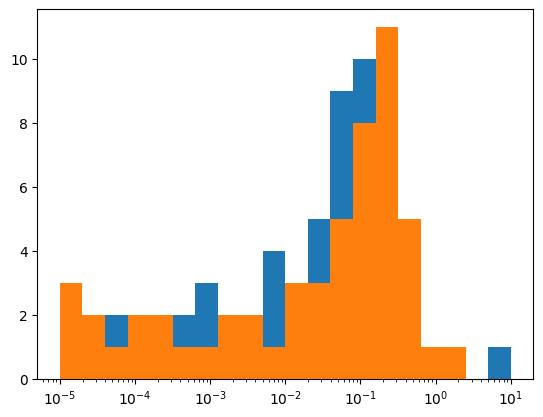

In [170]:
bins = np.logspace(-5, 1, 21)
#eig1 = np.real(choi_spectrum(model1.channel))
#eig2 = np.real(choi_spectrum(model2.channel))
#eig3 = np.real(choi_spectrum(model3.channel))
eig4 = np.real(choi_spectrum(model4.channel))
eig5 = np.real(choi_spectrum(model5.channel))
eig6 = np.real(choi_spectrum(model6.channel))

plt.hist(eig1, bins=bins)
#plt.hist(eig2, bins=bins)
#plt.hist(eig3, bins=bins)
#plt.hist(eig4, bins=bins)
plt.hist(eig5, bins=bins)
plt.xscale("log")
plt.show()

In [174]:
def spectrum_to_radial(spectrum):
    radial = tf.norm(spectrum, axis=1)
    return radial

In [175]:
def find_outer_inner_R(spectrum_list, alpha=0.05):
    radial_list = [spectrum_to_radial(spectrum) for spectrum in spectrum_list]
    radial_sorted = np.real(np.sort(np.concatenate(radial_list)))
    tail = ceil(alpha*len(radial_sorted))
    R_pluss = np.median(radial_sorted[-tail:])
    R_minus = np.median(radial_sorted[:tail])
    return R_pluss, R_minus

In [176]:
R_list = [find_outer_inner_R([spectrum_list[i][:-1]]) for i in range(5)]
R_plus, R_minus = zip(*R_list)

In [177]:
print(R_plus)

(0.6969326119792412, 0.5137953339785726, 0.22795487178625987, 0.20829916051096878, 0.16875219029112198)


In [179]:
x = [30, 35, 40]

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

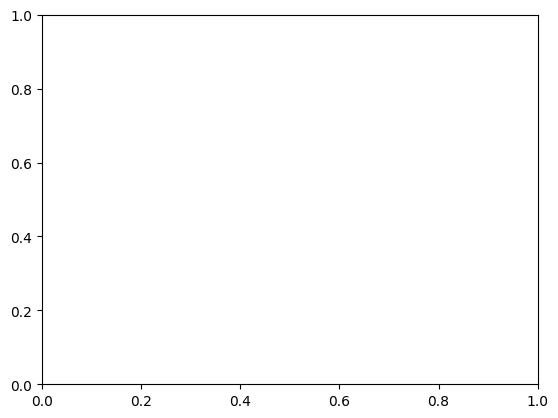

In [180]:
plt.plot(x, R_plus, "o")
plt.plot(x, R_minus, "o")
plt.show()